# Importing Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from glob import glob
import cv2
import random,os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,MaxPool2D
from tensorflow.keras.layers import BatchNormalization,Activation
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from keras.layers import Input
from tensorflow.keras.layers import Conv2D,Convolution1D

from IPython.display import SVG,Image
import tensorflow as tf
print("Tensorflow_version:",tf.__version__)

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tensorflow_version: 2.13.0


# Loading dataset

# Data Preprocessing

In [2]:
img_size=48
batch_size=64
datagen_train=ImageDataGenerator()
train_generator=datagen_train.flow_from_directory('/kaggle/input/fer2013/train',target_size=(img_size,img_size),
                                                 color_mode="grayscale",
                                                 batch_size=batch_size,
                                                 class_mode="categorical",
                                                 shuffle=True)

Found 28709 images belonging to 7 classes.


In [3]:
datagen_validation=ImageDataGenerator()
validation_generator=datagen_validation.flow_from_directory("/kaggle/input/fer2013/test/",target_size=(img_size,img_size),
                                                 color_mode="grayscale",
                                                 batch_size=batch_size,
                                                 class_mode="categorical",
                                                 shuffle=True)

Found 7178 images belonging to 7 classes.


# Defining model

In [4]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size,padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    return x

In [5]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

In [6]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,64,(3,3))
    conv_2 = Convolution(conv_1,128,(5,5))
    conv_3 = Convolution(conv_2,512,(3,3))
    conv_4 = Convolution(conv_3,512,(3,3))
    
    flatten = Flatten()(conv_4)
    dense_1 = Dense_f(flatten,256)
    dense_2 = Dense_f(dense_1,512)
    output = Dense(7,activation = 'softmax')(dense_2)
    
    model = Model(inputs = [inputs], outputs = [output])
    
    opt = Adam(lr = 0.0005)
    model.compile(loss = ['categorical_crossentropy'], optimizer = opt,
                          metrics = ['accuracy'])
    return model   

In [7]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

# Initialization of model



In [8]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint('model_weights.h5',monitor = 'val_accuracy', 
                              save_weights_only = True, mode = 'max', 
                              verbose = -1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 2, min_lr = 0.00001)
callbacks = [checkpoint,reduce_lr]

# Model Training

In [9]:
history=model.fit(x=train_generator,steps_per_epoch=steps_per_epoch,epochs=epochs,
                 validation_data=validation_generator,validation_steps=validation_steps,
                 callbacks=callbacks)

Epoch 1/15


2024-01-25 16:43:51.756242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - 172s 367ms/step - loss: 1.7564 - accuracy: 0.3250 - val_loss: 1.5544 - val_accuracy: 0.4060 - lr: 0.0010
Epoch 2/15
448/448 [==============================] - 27s 60ms/step - loss: 1.3982 - accuracy: 0.4666 - val_loss: 1.2825 - val_accuracy: 0.5120 - lr: 0.0010
Epoch 3/15
448/448 [==============================] - 28s 63ms/step - loss: 1.2583 - accuracy: 0.5198 - val_loss: 1.3119 - val_accuracy: 0.4918 - lr: 0.0010
Epoch 4/15
448/448 [==============================] - 28s 62ms/step - loss: 1.0544 - accuracy: 0.6020 - val_loss: 1.0697 - val_accuracy: 0.5917 - lr: 1.0000e-04
Epoch 6/15
448/448 [==============================] - 29s 64ms/step - loss: 1.0063 - accuracy: 0.6212 - val_loss: 1.0469 - val_accuracy: 0.6102 - lr: 1.0000e-04
Epoch 7/15
448/448 [==============================] - 28s 62ms/step - loss: 0.9850 - accuracy: 0.6279 - val_loss: 1.0454 - val_accuracy: 0.6071 - lr: 1.0000e-04
Epoch 8/15
448/448 [==============================] - 2

# Evaluation of model

In [10]:
model.evaluate(validation_generator)

113/113 [==============================] - 6s 55ms/step - loss: 1.0001 - accuracy: 0.6381


[1.0001214742660522, 0.6380607485771179]

In [11]:
model.save("Emotion_detection.h5")

# Plotting Loss

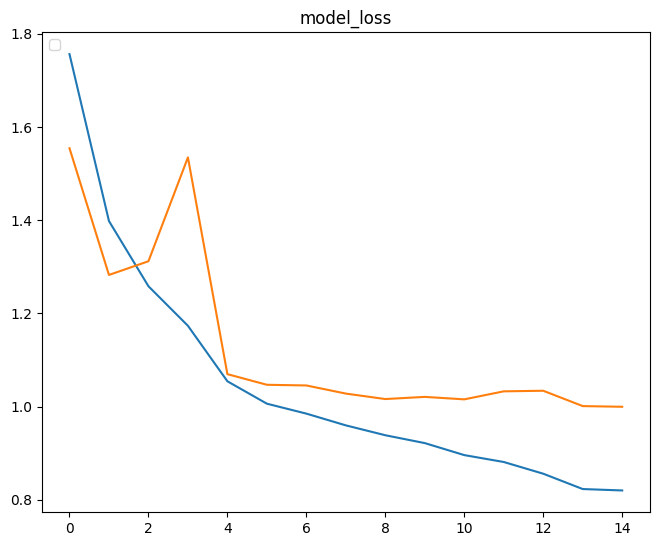

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.legend('train','validation',loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)


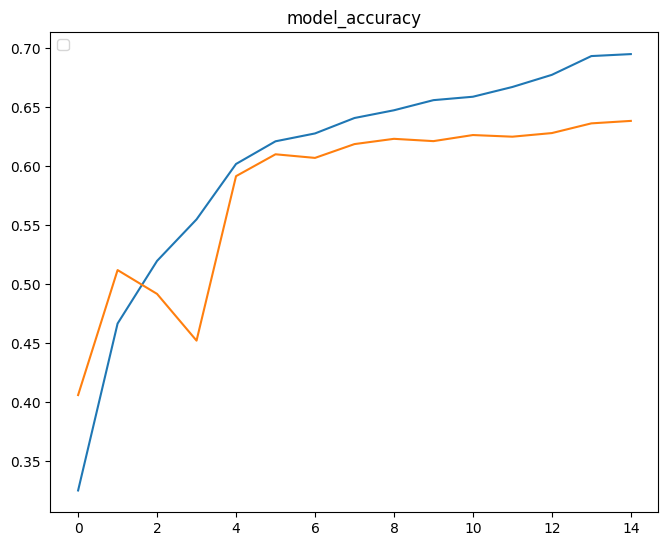

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.legend('train','validation',loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)


# saving the model

In [14]:
model_json = model.to_json()
with open('model_a.json','w') as json_file:
    json_file.write(model_json)